# 1. Preparação da base

Para fazer modelagens de séries temporais, selecionei o produto mais pedido do inventário. Assim, garantindo que existem dados suficientes para criar moelos de séries temporais consistentes.

O produto mais vendido é o de código 2e35421c34fb588ba40a0c57b3971d24 e teve 21723 quantidades vendidas em 20944 pedidos.

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

In [168]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [169]:
inventory = pd.read_csv('desafio.csv', sep=',')
inventory.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [170]:
inventory['capture_date'] = pd.to_datetime(inventory['capture_date'])

In [171]:
products_quantity = inventory.groupby('code').count().sort_values('order_id', ascending=False).reset_index()
df = inventory[(inventory['code'] == products_quantity[(products_quantity.index == 0)]['code'][0])]
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
85998,8b479b53a949fb676ef706e3f541044b,2e35421c34fb588ba40a0c57b3971d24,1,364.40,33.7070,65.592,0.0000,388128822cef4b4f102ae881e040a64b,213.4382,cancelado boleto não pago,2016-06-01,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
85999,86e829d5b8e412b896f381720937aece,2e35421c34fb588ba40a0c57b3971d24,1,369.40,34.1695,66.492,0.0000,388128822cef4b4f102ae881e040a64b,213.4382,cancelado boleto não pago,2016-06-01,0000-00-00,captado,98defd6ee70dfb1dea416cecdf391f58
86000,6d5afe0d607aa2462081f2f45473f728,2e35421c34fb588ba40a0c57b3971d24,1,386.07,35.7115,0.000,73.8368,388128822cef4b4f102ae881e040a64b,213.4382,entrega total,2016-06-01,2016-06-02,processado,fc7020775a7cdf161ab5267985c54601
86001,71bc4c02ae9d428a900c37d9c07ac733,2e35421c34fb588ba40a0c57b3971d24,1,369.40,34.1695,0.000,73.8368,388128822cef4b4f102ae881e040a64b,213.4382,entrega total,2016-06-01,2016-06-02,processado,b76eb9b8fc0f17098812da9117d3e500
86002,12c42aa7fbbfc434b3d5d2fedfcb81e7,2e35421c34fb588ba40a0c57b3971d24,1,369.40,34.1695,0.000,73.8368,388128822cef4b4f102ae881e040a64b,213.4382,entrega total,2016-06-01,2016-06-01,processado,b76eb9b8fc0f17098812da9117d3e500


In [172]:
qtd_produtos = inventory[(inventory['code'] == products_quantity[(products_quantity.index == 0)]['code'][0])].sum()['quantity']
qtd_pedidos = inventory[(inventory['code'] == products_quantity[(products_quantity.index == 0)]['code'][0])].count().unique()
print("Foram vendidas " + str(qtd_produtos) + " unidades em " + str(qtd_pedidos[0]) + " pedidos diferentes.")

Foram vendidas 21723 unidades em 20944 pedidos diferentes.


# 2. Análise exploratória

In [173]:
sns.set(rc={'figure.figsize':(18, 10)})

<AxesSubplot:xlabel='capture_date'>

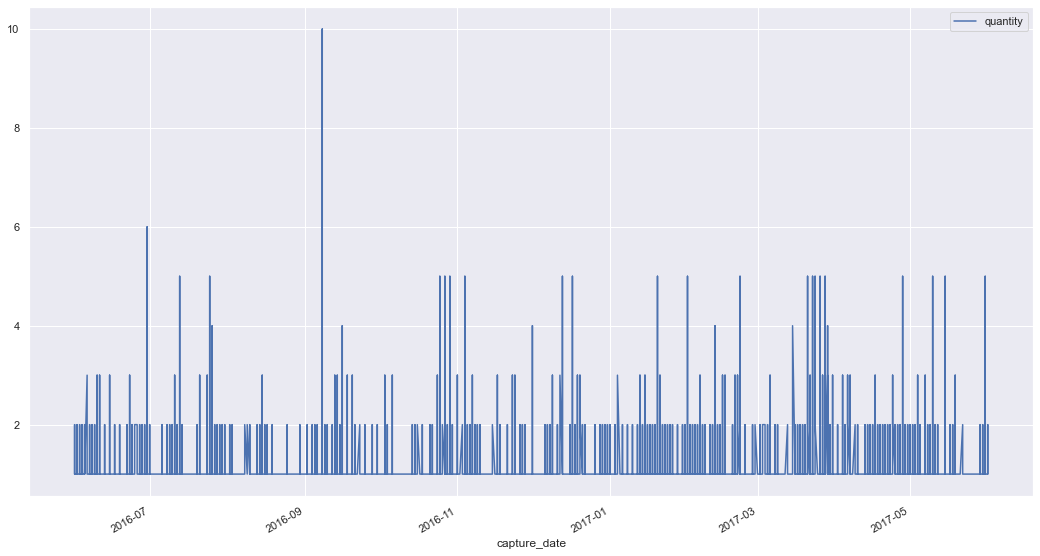

In [174]:
df.plot(x='capture_date', y='quantity')

<ipython-input-175-d90a38b43a07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['capture_date'].dt.strftime('%Y-%m')
<ipython-input-175-d90a38b43a07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = pd.DatetimeIndex(df['capture_date']).day


Text(0.5, 1.0, 'Quantidade vendida por dia')

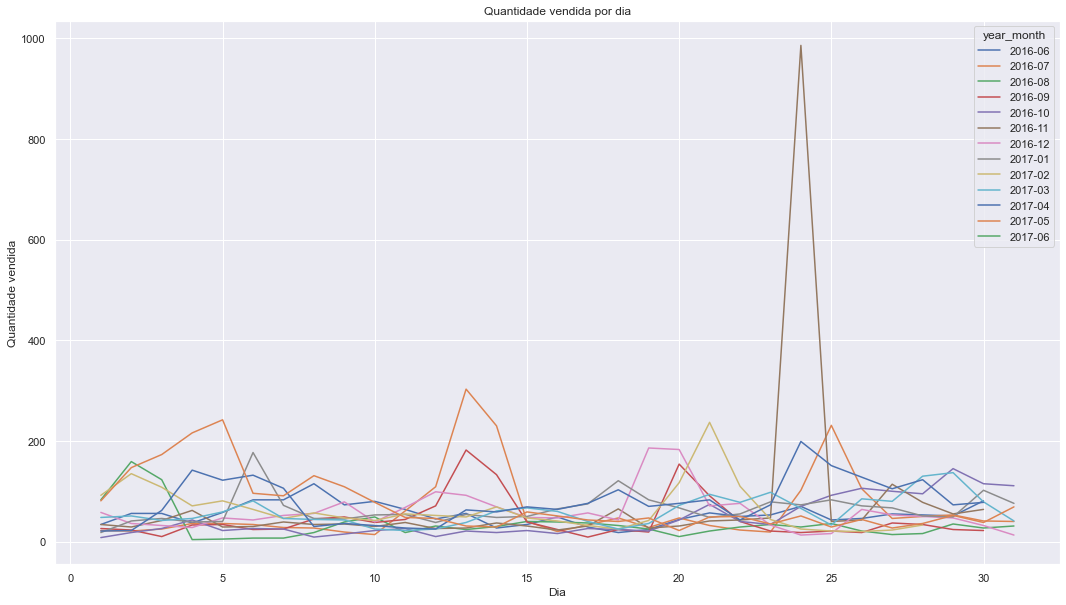

In [175]:
df['year_month'] = df['capture_date'].dt.strftime('%Y-%m')
df['day'] = pd.DatetimeIndex(df['capture_date']).day
months_df = df.loc[:, ('quantity', 'year_month', 'day')]
months_grouped = months_df.groupby(['day', 'year_month']).agg(sum_qtd=("quantity", "sum")).reset_index()
months_pivot = months_grouped.pivot(index='day', columns='year_month', values='sum_qtd').reset_index()
ax = months_pivot.plot(x='day', xlabel='Dia', ylabel='Quantidade vendida')
ax.set_title("Quantidade vendida por dia")

# Modelos de séries temporais

# Média móvel simples

In [185]:
df_mm = df.loc[:, ('quantity', 'year_month')]
df_mm = df_mm.groupby(['year_month']).agg(sum_qtd=("quantity", "sum")).reset_index().sort_values('year_month', ascending=True)

In [186]:
df_mms = df_mm
df_mms['SMA_12'] = df_mms.sum_qtd.rolling(12, min_periods=1).mean()
df_mms['SMA_4'] = df_mms.sum_qtd.rolling(3).mean()

Text(0, 0.5, 'Quantidade')

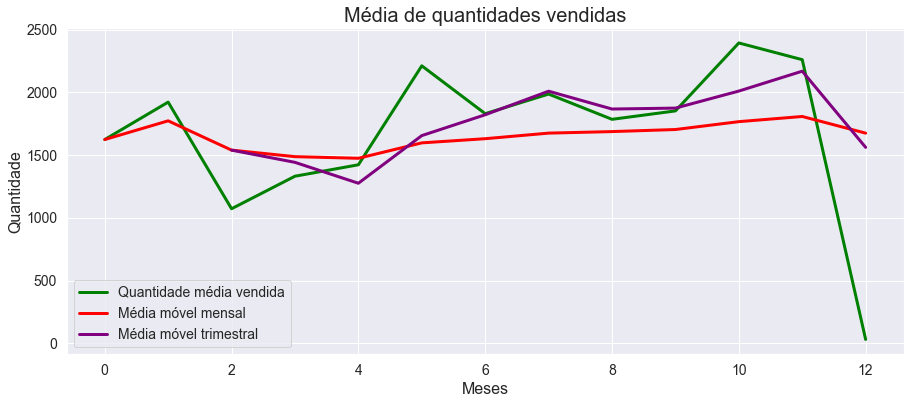

In [187]:
colors = ['green', 'red', 'purple']

df_mms.plot(color=colors, linewidth=3, figsize=(15,6))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Quantidade média vendida', 'Média móvel mensal', 'Média móvel trimestral'], fontsize=14)

# title and labels
plt.title('Média de quantidades vendidas', fontsize=20)
plt.xlabel('Meses', fontsize=16)
plt.ylabel('Quantidade', fontsize=16)

# ARMA

In [188]:
# Divisão em treino e teste

df_mm = df.loc[:, ('quantity', 'year_month')]
df_mm = df_mm.groupby(['year_month']).agg(sum_qtd=("quantity", "sum")).reset_index().sort_values('year_month', ascending=True)

In [193]:
start_m = df_mm['year_month'].min()
for i, s in enumerate(start_m):
    if i == len(start_m) - 1:
        new_s = str(int(s) - 1)
        start_m = start_m[:-1]
        start_m += new_s
end_m = df_mm['year_month'].max()
df_arma.index = pd.Index(pd.date_range(start_m, end=end_m, freq="M"))
df_arma = df_mm.drop(['year_month'], axis=1)
df_arma.head()

,sum_qtd
0,1624
1,1922
2,1073
3,1332
4,1423


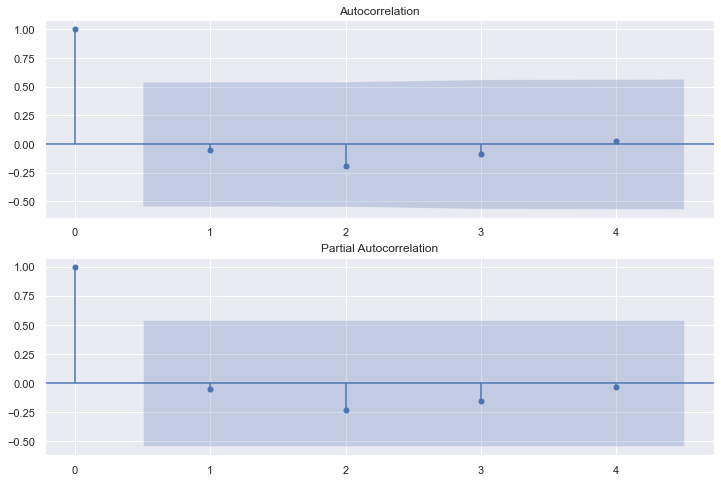

In [194]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_arma.values.squeeze(), lags=4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_arma, lags=4, ax=ax2)

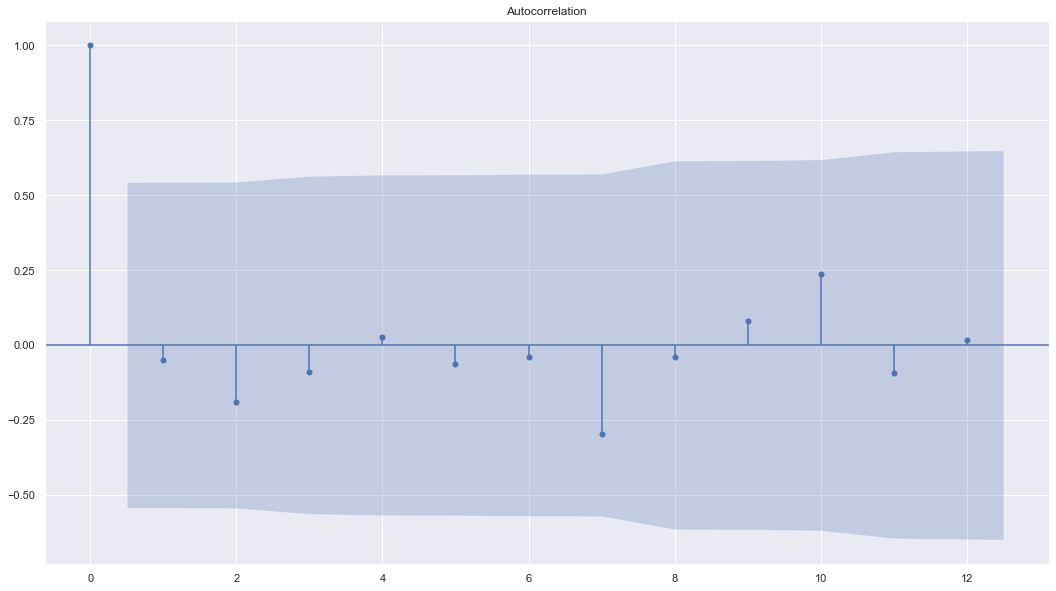

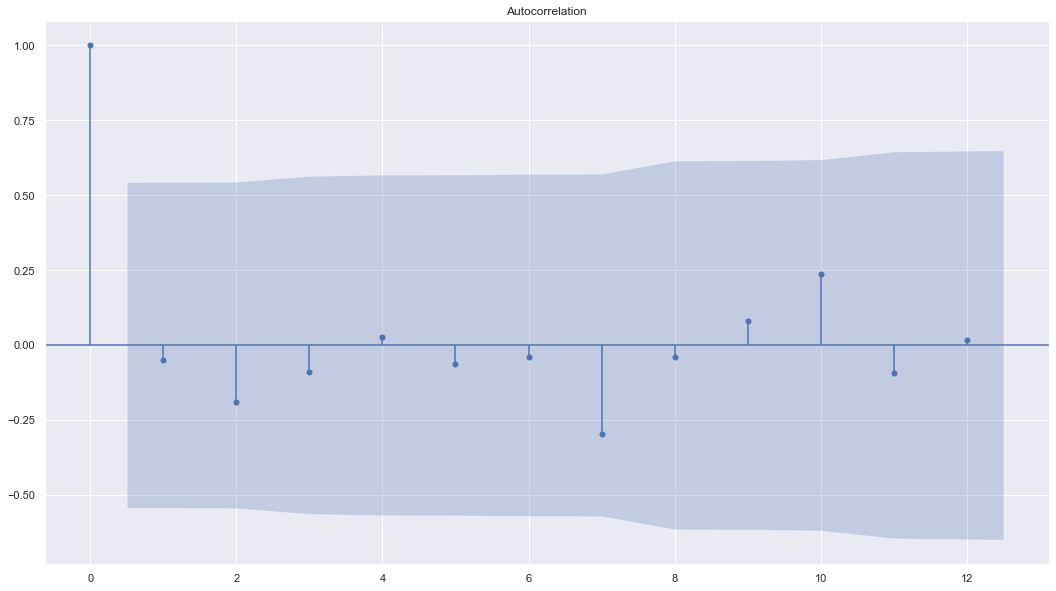

In [133]:
plot_acf(df_mm)

# Autoregression - Tentativa 1

In [195]:
# checar se é stationary
ad_fuller_result = adfuller(df_mm['sum_qtd'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.212232064747535
p-value: 0.20183591482464075


In [196]:
df_mm['sum_qtd'] = np.log(df_mm['sum_qtd'])
df_mm['sum_qtd'] = df_mm['sum_qtd'].diff()
# por que dropou o index 0?
df_mm = df_mm.drop(df_mm.index[0])
df_mm.head()

,year_month,sum_qtd
1,2016-07,0.168474
2,2016-08,-0.582908
3,2016-09,0.216223
4,2016-10,0.066086
5,2016-11,0.440678


In [197]:
# checar se é stationary: não é. e agora?
ad_fuller_result = adfuller(df_mm['sum_qtd'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.5569207381176295
p-value: 0.8804221360188542


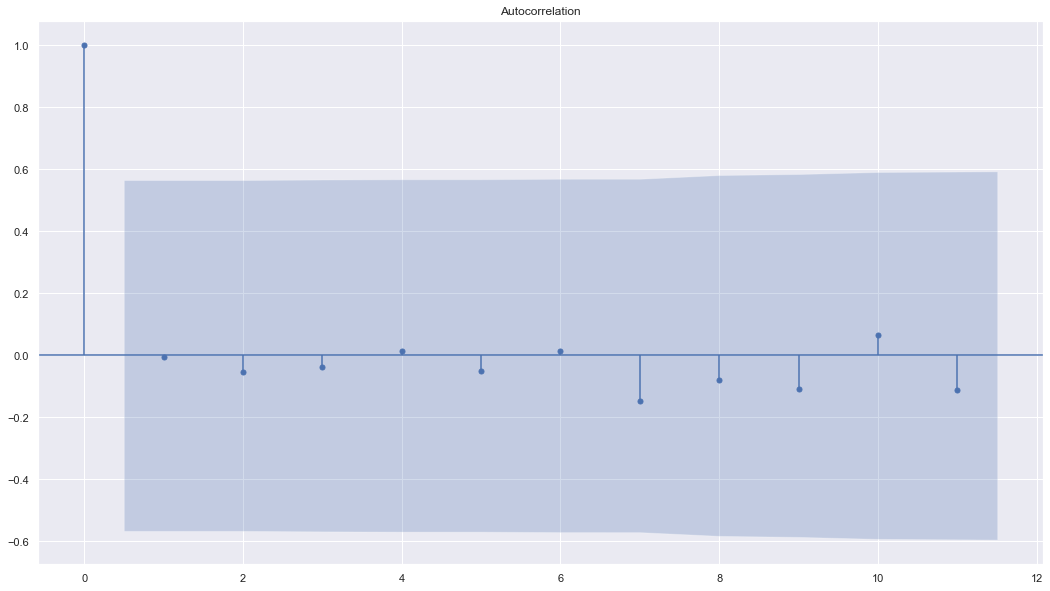

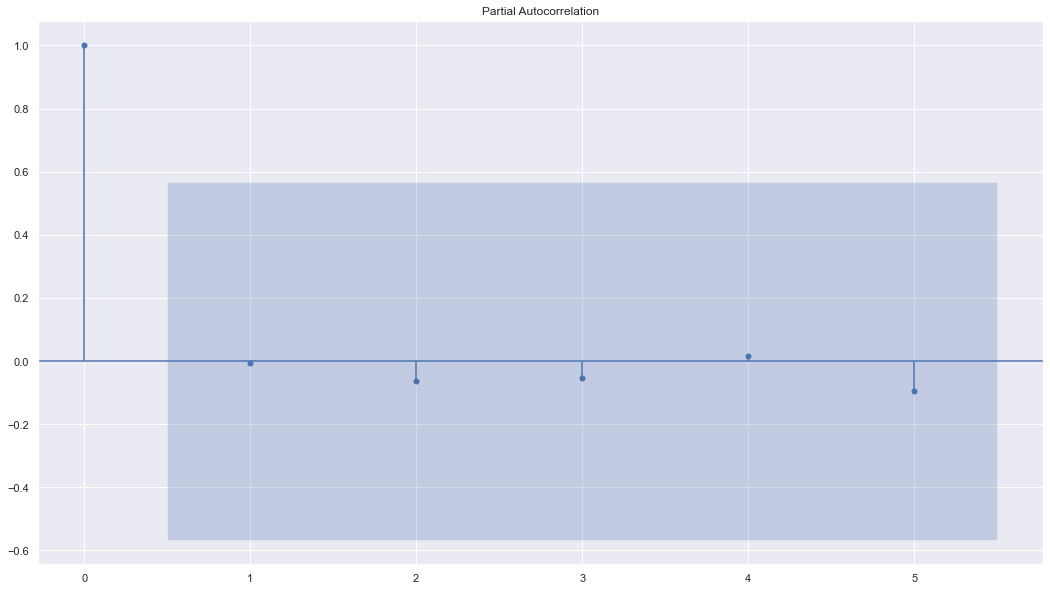

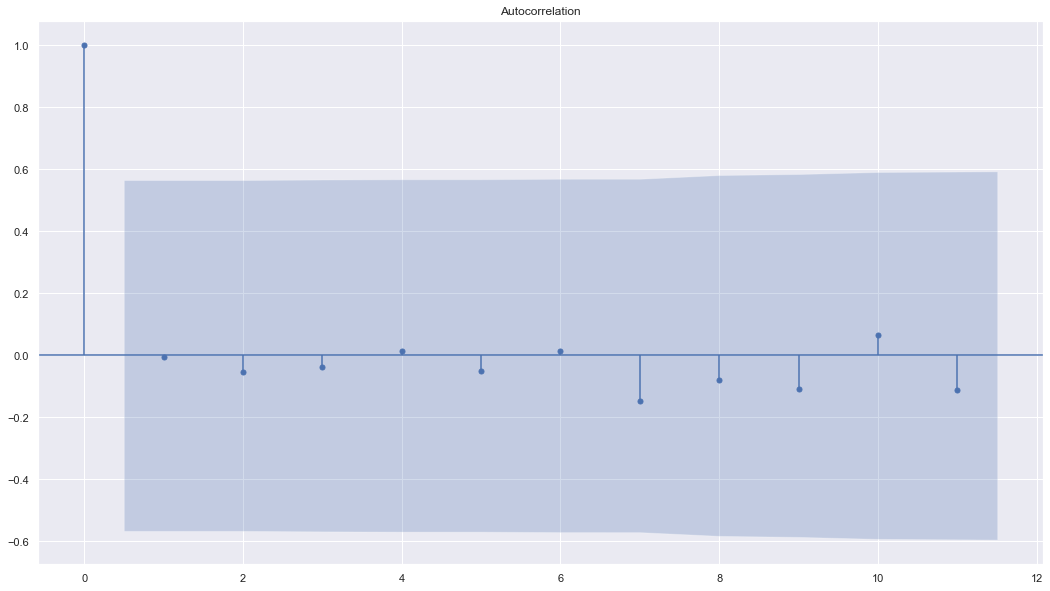

In [198]:
plot_pacf(df_mm['sum_qtd'], lags=5)
plot_acf(df_mm['sum_qtd'])

In [199]:
# order 1 porque depois do lag 1 não é significativo?
# essa seria a equação?
rho, sigma = yule_walker(df_mm['sum_qtd'], 1)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [0.00671166]
sigma: 1.2102724474990487


# Autoregression - Tentativa 2

In [200]:
# Divisão em treino e teste

df_mm = df.loc[:, ('quantity', 'year_month')]
df_mm = df_mm.groupby(['year_month']).agg(sum_qtd=("quantity", "sum")).reset_index().sort_values('year_month', ascending=True)
df_mm.index = df_mm['year_month']
df_mm = df_mm.drop(['year_month'], axis=1)

train, test = train_test_split(df_mm, train_size=0.8, shuffle=False)

train

,sum_qtd
year_month,
2016-06,1624
2016-07,1922
2016-08,1073
2016-09,1332
2016-10,1423
2016-11,2211
2016-12,1830
2017-01,1986
2017-02,1785


In [201]:
# como selecionar o melhor número?
# não deveria dividir entre treino e teste? no exemplo da lib, a predição não é feita com dados de teste
ar_mod = AutoReg(df_mm, 3)
res = ar_mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                sum_qtd   No. Observations:                   13
Model:                     AutoReg(3)   Log Likelihood                 -77.919
Method:               Conditional MLE   S.D. of innovations            585.813
Date:                Wed, 20 Oct 2021   AIC                             13.746
Time:                        17:40:41   BIC                             13.897
Sample:                    09-01-2016   HQIC                            13.580
                         - 06-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3012.6497   1271.692      2.369      0.018     520.180    5505.120
sum_qtd.L1     0.2159      0.496      0.436      0.663      -0.756       1.188
sum_qtd.L2    -0.6871      0.532     -1.292      0.1

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


No handles with labels found to put in legend.


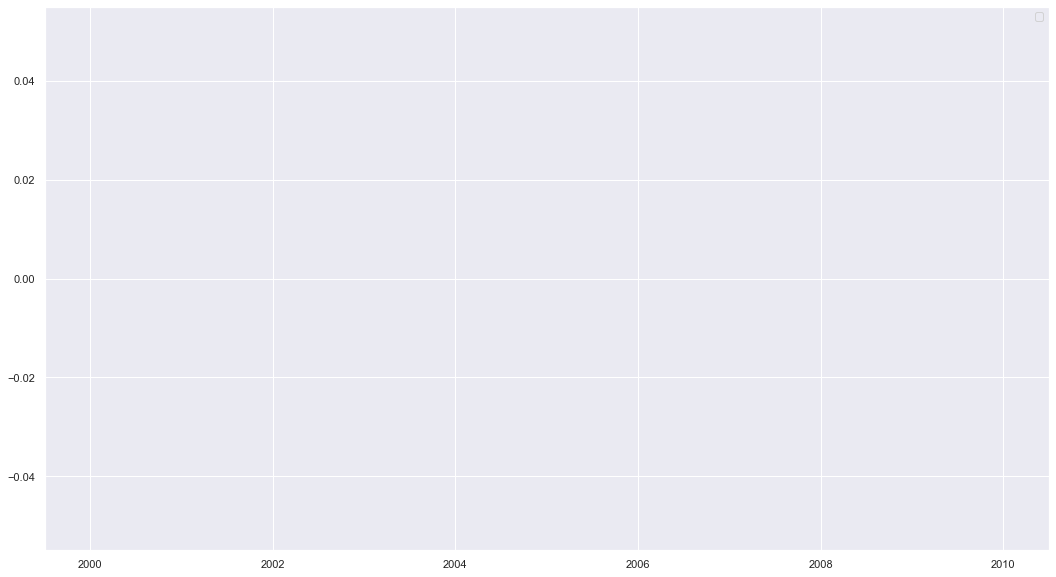

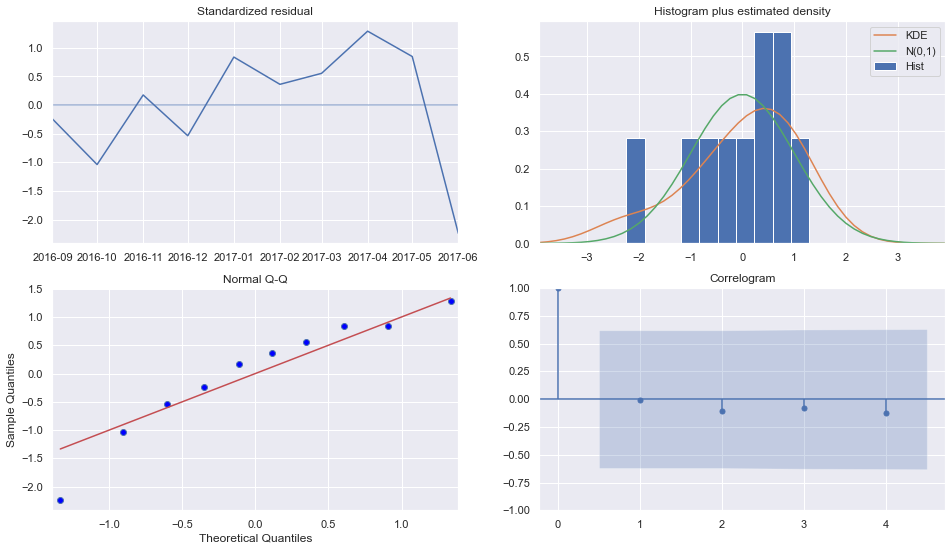

In [202]:
fig = res.plot_predict(2, 2)
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=4)

# ARIMA

In [215]:
mod = ARIMA(train, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                sum_qtd   No. Observations:                   10
Model:                     ARMA(1, 0)   Log Likelihood                 -71.867
Method:                       css-mle   S.D. of innovations            319.417
Date:                Wed, 20 Oct 2021   AIC                            149.733
Time:                        17:46:57   BIC                            150.641
Sample:                    06-01-2016   HQIC                           148.738
                         - 03-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1705.0220    117.595     14.499      0.000    1474.541    1935.503
ar.L1.sum_qtd     0.1563      0.300      0.520      0.603      -0.432       0.745
                                    Root

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency

In [217]:
# os meses estão errados; não consegui usar os dados de teste separados
res.predict()

2016-06-01    1705.022018
2016-07-01    1692.357486
2016-08-01    1738.937794
2016-09-01    1606.230810
2016-10-01    1646.715037
2016-11-01    1660.939225
2016-12-01    1784.111313
2017-01-01    1724.557296
2017-02-01    1748.941618
2017-03-01    1717.523357
Freq: MS, dtype: float64

# Referências

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c
https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_arma_0.html
https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
